In [ ]:
%pip install wandb torchvision tqdm transformers

In [47]:
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import math
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as tvf
import numpy as np
import matplotlib.pyplot as plt
from transformers import get_cosine_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from tqdm.autonotebook import tqdm

import gc
import wandb
from functools import partial
import os

os.environ['WANDB_API_KEY'] = ""
wandb.login()

True

In [48]:
# RoPE
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1]), f"x.shape == {x.shape}, freqs.shape == {freqs_cis.shape}"
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [49]:
class MultiheadAttention(nn.Module):
    def __init__(self, model_dim, num_heads, dropout=.1):
        super().__init__()
        assert(model_dim % num_heads == 0)
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads

        self.qkv = nn.Linear(model_dim, model_dim * 3, bias=False)
        self.c_proj = nn.Linear(model_dim, model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, freqs_cis):
        q, k ,v = self.qkv(x).split(self.model_dim, dim=-1)
        B, L, D = q.shape

        q = q.view((B, L, self.num_heads, self.head_dim))
        k = k.view((B, L, self.num_heads, self.head_dim))
        v = v.view((B, L, self.num_heads, self.head_dim)).transpose(1,2)

        q, k = apply_rotary_emb(q, k, freqs_cis)

        q = q.transpose(1,2)
        k = k.transpose(1,2)
        
        res = torch.nn.functional.scaled_dot_product_attention(
            q, k, v,
            attn_mask=None,
            dropout_p=0.0,
            is_causal=True,
            scale=None)
            
        res = res.transpose(1,2).contiguous().view((B, L, -1))
        return self.dropout(self.c_proj(res))

class FeedForward(nn.Module):
    def __init__(self, model_dim, ff_dim, dropout=.1):
        super().__init__()
        self.c_fc = nn.Linear(model_dim, ff_dim)
        self.c_proj = nn.Linear(ff_dim, model_dim)
        self.SiLU = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):
        x = self.SiLU(self.c_fc(x))
        return self.dropout(self.c_proj(x))

class TransformerBlock(nn.Module):
    def __init__(self, model_dim, num_heads, ff_dim, dropout=.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(model_dim)
        self.attn = MultiheadAttention(model_dim, num_heads, dropout)
        self.ln2 = nn.LayerNorm(model_dim)
        self.ff = FeedForward(model_dim, ff_dim, dropout)

    def forward(self, x, freqs_cis):
        x = x + self.attn(self.ln1(x), freqs_cis)
        x = x + self.ff(self.ln2(x))
        return x


class TransformerModel(nn.Module):
    def __init__(self, num_img_toks, special_toks, num_layers, max_seq_len, model_dim, num_heads, ff_dim, dropout=.1):
        super().__init__()
        
        self.model_in_special_toks = {tok : (num_img_toks + tok_idx) for tok_idx, tok in enumerate(special_toks)}

        self.model_in_vocab_size = num_img_toks + len(self.model_in_special_toks)

        self.tok_embed = nn.Embedding(self.model_in_vocab_size, model_dim)

        self.layers = nn.ModuleList(
            [TransformerBlock(model_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)]
        )

        self.model_out_vocab_size = num_img_toks

        self.ln_f = nn.LayerNorm(model_dim)
        self.gen_head = nn.Linear(model_dim, self.model_out_vocab_size)
        self.max_seq_len = max_seq_len

        self.freqs_cis = precompute_freqs_cis(model_dim // num_heads, self.max_seq_len + 2 * len(self.model_in_special_toks))
        # freqs_cis = precompute_freqs_cis(model_dim // num_heads, self.max_seq_len + 2 * len(self.model_in_special_toks))
        # self.register_buffer("freqs_cis", freqs_cis)
        
        
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * num_layers))
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def get_cls_idx(self, cls_toks):
        return [self.model_in_special_toks[cls_tok] for cls_tok in cls_toks]

    def forward(self, x, y):
        bsz = x.shape[0] if x is not None else len(y)
        # device = x.device
        # device = next(self.module.parameters()).device

        # y = torch.tensor(self.get_cls_idx(y), dtype=torch.long, device=device).reshape((bsz, 1))

        if x is not None:
            x = torch.cat((y, x), dim=1)
        else:
            x = y

        _, seqlen = x.shape

        h = self.tok_embed(x)
        self.freqs_cis = self.freqs_cis.to(h.device)
        freqs_cis = self.freqs_cis[:seqlen]

        for layer in self.layers:
            h = layer(h, freqs_cis)
        final = self.gen_head(self.ln_f(h))
        return final

    @torch.no_grad()
    def generate(self, bsz=32, temperature=1.0, use_max=False):
        device = next(model.module.layers[0].parameters()).device
        idx = None
        cls_toks = list(self.model_in_special_toks.values())
        cls_min = min(cls_toks)
        cls_max = max(cls_toks) + 1
        y = torch.randint(cls_min, cls_max, (bsz,1), dtype=torch.long, device=device)
        max_new_tokens = 28 * 28;
        t = tqdm(range(max_new_tokens), leave=False)
        t.set_description("Generating samples")
        for _ in t:
            logits = self(idx, y)
            logits = logits[:, -1, :] / temperature
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            if use_max:
                idx_next = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            if idx is not None:
                idx = torch.cat((idx, idx_next), dim=1)
            else:
                idx = idx_next

        return idx

def show_gen_img(model_out):
    bsz = model_out.shape[0]
    model_out = model_out.to('cpu').view(bsz, 1, 28, 28)
    img_grid = make_grid(model_out, nrow=4).to(torch.uint8)
    img = tvf.functional.to_pil_image(img_grid)
    plt.imshow(np.asarray(img))

def prep_generated_img(model_out):
    bsz = model_out.shape[0]
    model_out = model_out.to('cpu').view(bsz, 1, 28, 28)
    img_grid = make_grid(model_out, nrow=8).to(torch.uint8)
    img = tvf.functional.to_pil_image(img_grid)
    return np.asarray(img)


def gradient_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = {
    "epochs": 300,
    "lr": 1e-4,
    "lr_warmup_steps" : 100,
    "batch_size": 1024,
}

run = wandb.init(
    project="Simple ViT",
    notes="Softmax Attention based vision transformer",
    tags=["GPT", "MNIST", "RoPE"],
    config=config
)

ds_path = "MNIST/"
transforms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.long)])
mnist_train = torchvision.datasets.MNIST(ds_path, train=True, download=True, transform=transforms)

train_dataloader = DataLoader(
    mnist_train,
    batch_size=wandb.config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=8
)

In [51]:
special_toks = [i for i in range(10)] # num cls in MNIST

model = TransformerModel(
    num_img_toks=256,
    special_toks=special_toks,
    num_layers=9,
    max_seq_len=28*28,
    model_dim=512,
    num_heads=8,
    ff_dim=2048,
    dropout=.1
) #.to(device)

def encode_cls(inp, enc_dict):
    encoded = [enc_dict[cls_tok] for cls_tok in inp]
    return torch.tensor(encoded, dtype=torch.long).reshape((-1, 1))

encode_y = partial(encode_cls, enc_dict = model.model_in_special_toks)
    

model = torch.nn.DataParallel(model)
model.to(device)

s = round(sum([p.numel() for p in model.parameters()]) / 1e6, 2)
print(f"Model Size: {s}M params")

max_epoch = wandb.config['epochs']
epoch_steps = len(train_dataloader)
total_steps = epoch_steps * max_epoch


cls_weights = torch.ones((256))
cls_weights[0] = .1
optimizer = optim.RAdam(model.parameters(), lr=wandb.config['lr'])

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    wandb.config['lr_warmup_steps'],
    total_steps,
    num_cycles=3.5
)

loss_fn = nn.CrossEntropyLoss(cls_weights).to(device)

loss_hist = []


logs_per_epoch = 2
log_every = epoch_steps // logs_per_epoch

Model Size: 2.86M params


In [ ]:
gc.collect()
torch.cuda.empty_cache()

_step = 0

for epoch in range(max_epoch):
    dloader = tqdm(train_dataloader, total=len(train_dataloader))
    dloader.set_description(f"Epoch: {epoch: >3}/{max_epoch}")
    for n, (x, y) in enumerate(dloader):
        optimizer.zero_grad(set_to_none=True)
            
        x = x.to(device).flatten(start_dim=1)
        y = encode_y(y.tolist()).to(device)

        model_inp = x[:,:-1]
        model_out = model(model_inp, y)
        model_out = model_out.reshape((-1,model.module.model_out_vocab_size))

        target = x
        target = target.flatten()

        loss = loss_fn(model_out, target)
        loss.backward()
        
        grad_norm = gradient_norm(model)
        clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        loss_val = loss.to('cpu').item()
        loss_hist.append(loss_val)
        
        scheduler.step()
        
        if n != 0 and n % log_every == 0:
            log = {
                "loss" : loss_val,
                "lr" : scheduler.get_last_lr()[0],
                "grad_norm" : grad_norm,
                "epoch" : epoch
            }
            wandb.log(log, step = _step)
            
        dloader.set_postfix_str(f"Loss: {loss_val:.4}. G_norm: {grad_norm:.4f}. Lr: {scheduler.get_last_lr()[0]:.5f}")
        _step += 1
        
    model_out = model.module.generate(temperature=.8)
    prepd_img = prep_generated_img(model_out)
    log_img = wandb.Image(prepd_img, caption="Generated images")
    log = {'generated' :log_img, "epoch" : epoch}
    wandb.log(log, step = _step)
        
wandb.finish()

Generating samples:  78%|███████▊  | 615/784 [00:23<00:12, 13.02it/s] 

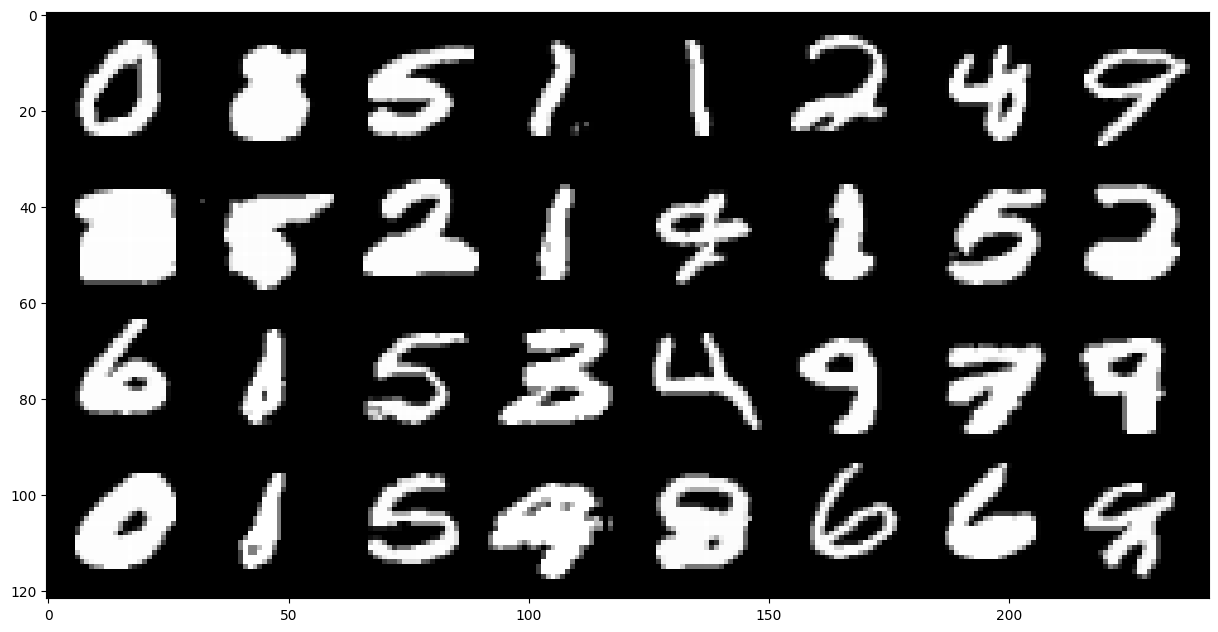

In [26]:
plt.figure(figsize=(15,30))
plt.imshow(prep_generated_img(model.module.generate(temperature=.8)), interpolation=None);

In [53]:
torch.save(
    {
    "epoch" : epoch,
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict()
    }, "Transformer_MNIST.cpkt"
)